# Multi-agent network

----------------------------------------------------------------------------------------------------------------------------------
*This section is taken from a yt video published by the [LangChain channel](https://www.youtube.com/@LangChain) on Multi-Agent workflows at this [link](https://youtu.be/hvAPnpSfSGo?si=QJw60byA9oRtSE5V). We will go over their notebooks and comment relevant/difficult sections.*

----------------------------------------------------------------------------------------------------------------------------------

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools. 

One way to approach complicated tasks is through a "divide-and-conquer" approach: create a specialized agent for each task or domain and route tasks to the correct "expert". This is an example of a [multi-agent network](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network) architecture.

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.

The resulting graph will look something like the following diagram:

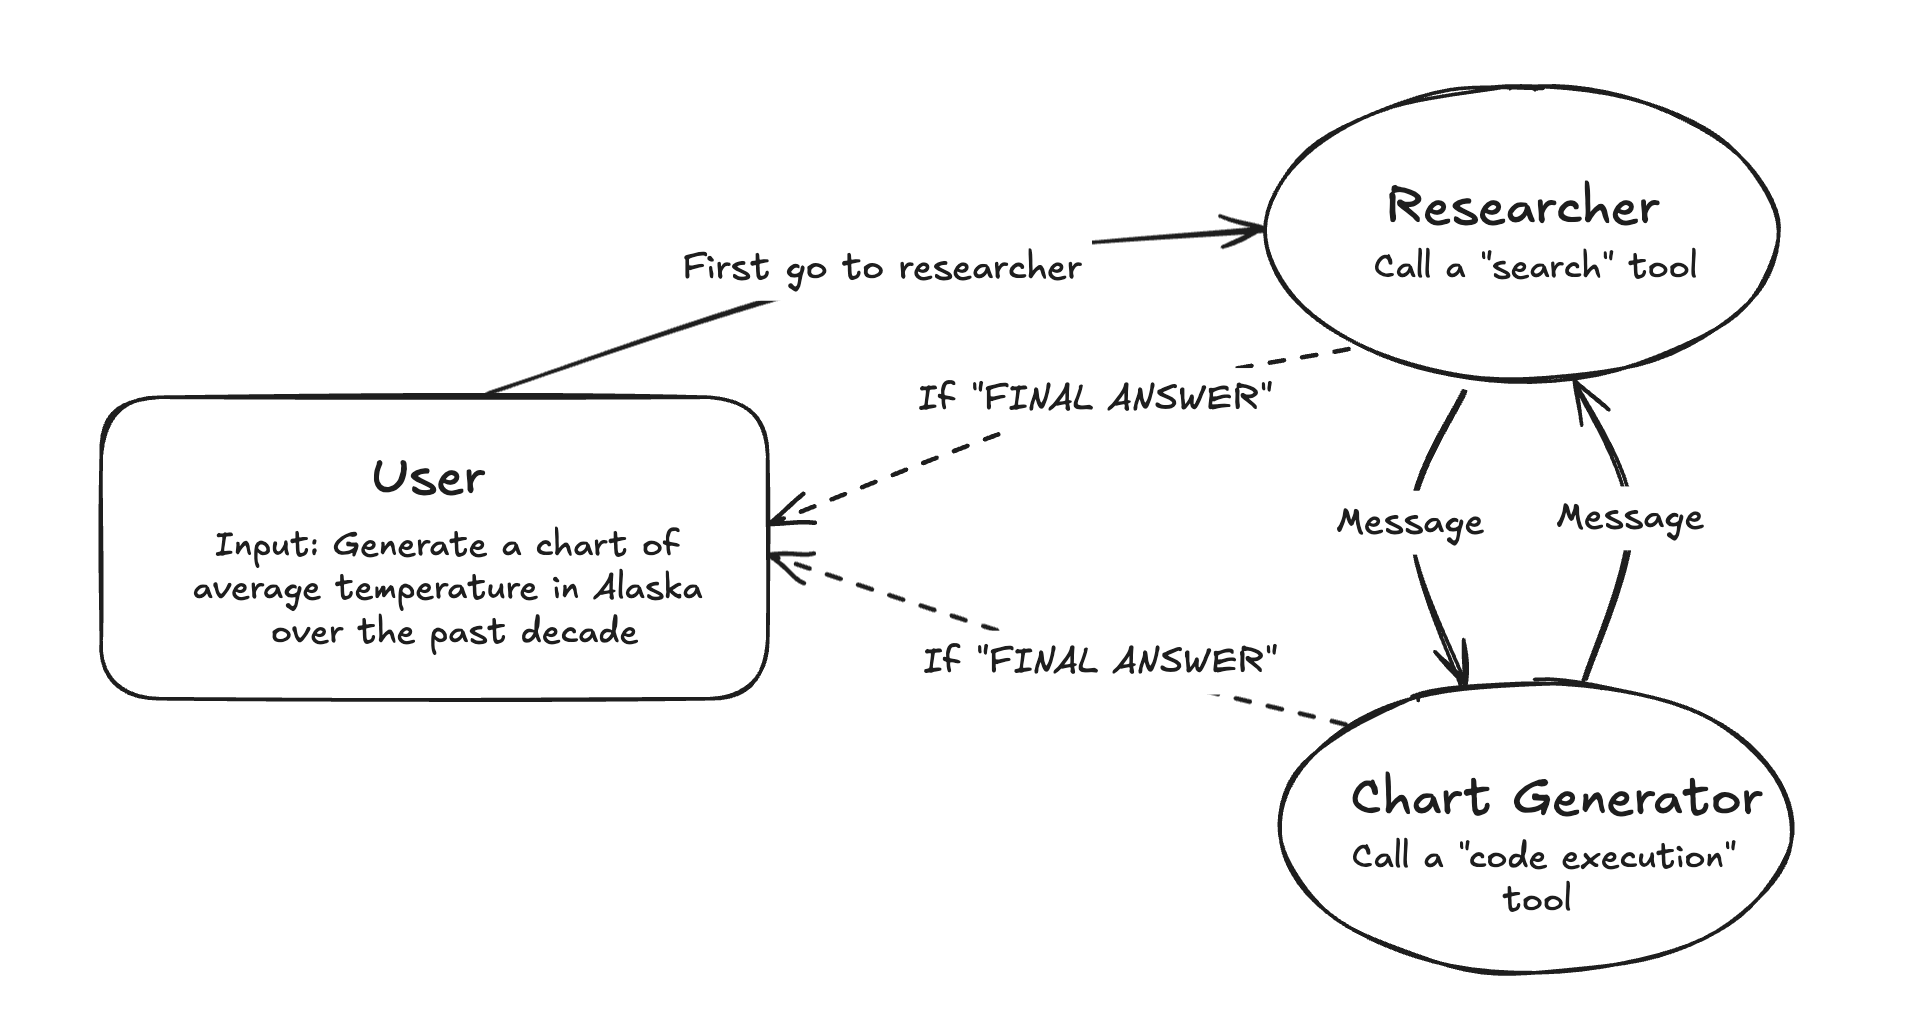

Before we get started, a quick note: this and other multi-agent notebooks are designed to show _how_ you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

## Setup

First, let's install our required packages and set our API keys:

In [1]:
%%capture --no-stderr
%pip install -U langchain_community langchain_anthropic langchain_experimental matplotlib langgraph

In [1]:
import getpass
import os
from dotenv import load_dotenv

load_dotenv()

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("ANTHROPIC_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Define tools

We will also define some tools that our agents will use in the future

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

/tmp/ipykernel_7193/948848266.py:7: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define Agent Nodes

We now need to define the nodes.

First, we'll create a utility to create a system prompt for each agent.

In [2]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [ ]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


llm = ChatAnthropic(model="claude-3-5-sonnet-latest")


def get_next_node(last_message: BaseMessage, goto: str):    
    # this will just be used to say: 
    # - from researcher always go to chart generator
    # - from chat generator always go to researcher
    # We're doing this because our flow is just the two talking to each other until one of them decide work is done.
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:  # Command[Literal["chart_generator", END]] means : the graph can go research -> chart OR research -> END
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # update the messages for the other agent
            "messages": result["messages"],
        },
        goto=goto,
    )


Let's understand what we did above.

* `get_next_node` is acting here as our router. Notice how we return the same `goto` string as the input if none of the agent returned `"FINAL ANSWER"`. This is because we want to go back and forth between the two collaborating agents until one of them decide the work is done (returning `"FINAL ANSWER"`). In other words, We're just creating a loop between the two agents. (*So why are we not doing so by building an edge that goes back and forth? See the note below*)  

* we create the researcher through the `create_react_agent` module, giving him the research tool we defined earlier;

* we define the node for our agent (each agent should have its node). notice that this time we didn't define a state in our usual way:
    ```python
    class AgentState(TypedDict):
        messages : Annotated[Sequence[BaseMessage], operator.add]
        # other useful trackers if needed
    ```
    but instead we are using the [`MessagesState` module](https://python.langchain.com/docs/how_to/message_history/#example-message-inputs) that does the same work for us. Of course it's more limited, in the sense that it only tracks messages and no other structure (like the name of the sender), which we could do instead in a custom class.  


> **Note: What is the `Command` type in LangChain, and what does the combination `Command[Literal["chart_generator", END]]` represent?**
>
> A thing that generated a lot of confusion for me is the use of a `Command` at the return type of nodes, and the fact that later on, when we build the graph, we never add an edge that connects the agents we created. So how does the system know that it has to route the flow depending on the `get_next_node function`? These two things are connected. It's literally the use of `Command` as return type that does this. Let me explain.
>
> The quickest explanation comes directly by [LangGraph Graph API Overview](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges): "Use `Command` to *combine state updates and routing in a single function*". 
>
> But what does this mean exactly? Let's dig deeper in the [`Command` overview](https://langchain-ai.github.io/langgraph/concepts/low_level/#command):
>
> *"It can be useful to combine control flow (edges) and state updates (nodes). For example, you might want to BOTH perform state updates AND decide which node to go to next in the SAME node. LangGraph provides a way to do so by returning a `Command` object from node functions:"*
>
>```python
>def my_node(state: State) -> Command[Literal["my_other_node"]]:
>    return Command(
>        # state update
>        update={"foo": "bar"},
>        # control flow
>        goto="my_other_node"
>    )
>```
> This is exactly what we do above. Since we wanted to BOTH route to the next node AND update the state messages, we used `Command`. This is very useful.
>
> With `Command` you can also achieve dynamic control flow behavior (identical to conditional edges):
>
>```python
>def my_node(state: State) -> Command[Literal["my_other_node"]]:
>    if state["foo"] == "bar":
>        return Command(update={"foo": "baz"}, goto="my_other_node")
>```
> ---------------
>
> **Important:** When returning Command in your node functions, you must add return type annotations with the list of node names the node is routing to, e.g. `Command[Literal["my_other_node"]]`. This is necessary for the graph rendering and tells LangGraph that `my_node` can navigate to `my_other_node`.
>
> ----------------
>
> **So, When should I use Command instead of conditional edges?**
>
>- *Use Command when you need to both update the graph state and route to a different node*. For example, when implementing multi-agent handoffs where it's important to route to a different agent and pass some information to that agent.
>
>- *Use conditional edges to route between nodes conditionally without updating the state*.
>
> Here you can find a clarifying guide on [how to combine control flow and state updates with `Command`](https://langchain-ai.github.io/langgraph/how-tos/graph-api/#combine-control-flow-and-state-updates-with-command).

Now we define the chart creator:

In [15]:
# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:    # Again meaning: we can go chart -> researcher OR chart -> END
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

### Define the Graph

We can now put it all together and define the graph!

In [16]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

Notice how we are not defining edges between researcher <-> chart_generator and edges to END. This is because we used `Command[Literal["..."]]`. 

langgraph bibles: 
- https://langchain-ai.github.io/langgraph/how-tos/graph-api/
- https://langchain-ai.github.io/langgraph/concepts/low_level/#command

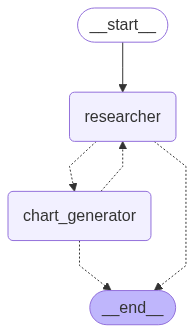

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='441ecde5-2d9d-4443-b282-9b5144b5ad6e'), AIMessage(content=[{'text': "I'll help research the UK's GDP data for the past 5 years. Let me search for this information.", 'type': 'text'}, {'id': 'toolu_019pJHPxBaV3P8YS8Y9cbUYt', 'input': {'query': 'UK GDP annual data past 5 years'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01J21AWfb3NYCnSB6uNFk4t9', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 555, 'output_tokens': 91, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run--ac478191-0759-4c63-adb1-cf168dbb6de3-0', tool_calls=[{'nam

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Python REPL can execute arbitrary code. Use with caution.
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


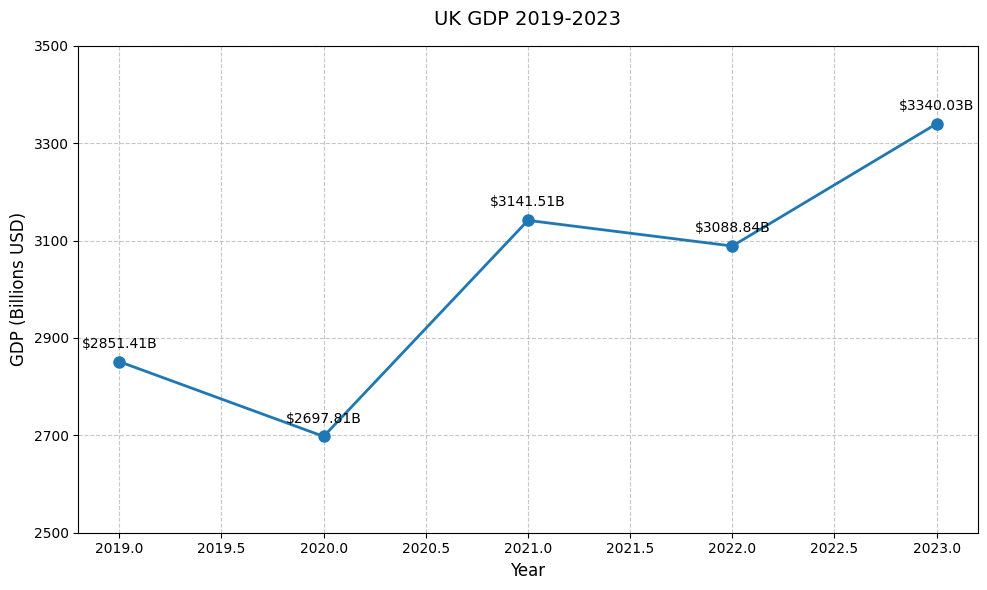

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Task chart_generator with path ('__pregel_pull', 'chart_generator') wrote to unknown channel branch:to:__end__, ignoring it.


{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='441ecde5-2d9d-4443-b282-9b5144b5ad6e'), AIMessage(content=[{'text': "I'll help research the UK's GDP data for the past 5 years. Let me search for this information.", 'type': 'text'}, {'id': 'toolu_019pJHPxBaV3P8YS8Y9cbUYt', 'input': {'query': 'UK GDP annual data past 5 years'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01J21AWfb3NYCnSB6uNFk4t9', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 555, 'output_tokens': 91, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run--ac478191-0759-4c63-adb1-cf168dbb6de3-0', tool_calls=[

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [ ]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")